In [8]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from causalgraphicalmodels import CausalGraphicalModel
import pickle

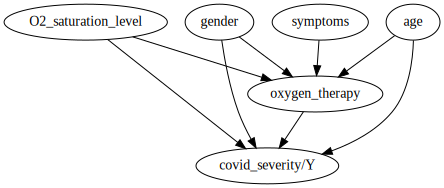

In [9]:
covid_dag_simple = CausalGraphicalModel(
    nodes=["covid_severity/Y", 
           "oxygen_therapy",
           "age",
           "O2_saturation_level","gender","symptoms",],
    edges=[
        ("O2_saturation_level","oxygen_therapy"),
        ("O2_saturation_level","covid_severity/Y"),
        ("oxygen_therapy", "covid_severity/Y"),
        ("symptoms","oxygen_therapy"),
        ("age","covid_severity/Y"),
        ("gender","covid_severity/Y"),
        ("gender","oxygen_therapy"),
        ("age","oxygen_therapy"),
    ]
)
covid_dag_simple.draw()

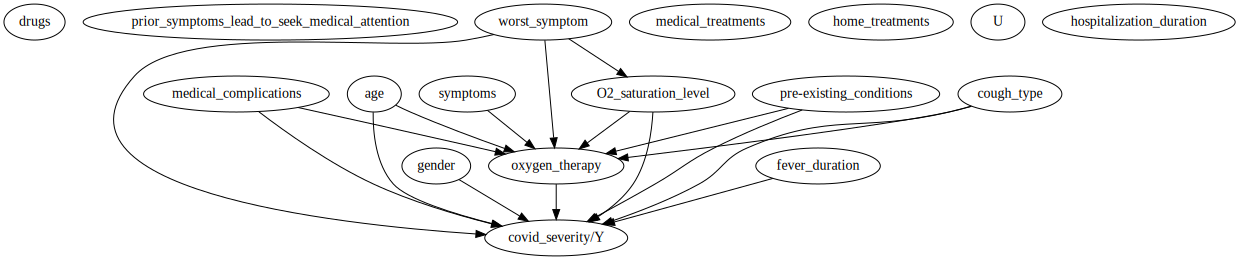

In [10]:
covid_dag = CausalGraphicalModel(
    nodes=["covid_severity/Y", "prior_symptoms_lead_to_seek_medical_attention",
           "oxygen_therapy","fever_duration","cough_type","home_treatments","drugs",
           "age","symptoms","worst_symptom","hospitalization_duration","medical_treatments",
           "O2_saturation_level","gender","medical_complications","pre-existing_conditions","U"],
    edges=[
        ("O2_saturation_level","oxygen_therapy"),
        ("O2_saturation_level","covid_severity/Y"),
        ("oxygen_therapy", "covid_severity/Y"),
        ("medical_complications","covid_severity/Y"),
        ("medical_complications","oxygen_therapy"),
        ("age","covid_severity/Y"),
        ("gender","covid_severity/Y"),
        ("age","oxygen_therapy"),
        ("symptoms","oxygen_therapy"),
        ("pre-existing_conditions","covid_severity/Y"),
        ("pre-existing_conditions","oxygen_therapy"),
        ("fever_duration","covid_severity/Y"),
        ("cough_type","oxygen_therapy"),
        ("cough_type","covid_severity/Y"),
        ("worst_symptom","covid_severity/Y"),
        ("worst_symptom","oxygen_therapy"),
        ("worst_symptom","O2_saturation_level")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
covid_dag.draw()

In [11]:
# with open('covid_data.pickle','rb') as handle:
#     covid_data = pickle.load(handle)
# covid_data

In [12]:
# del covid_data

In [13]:
path = '../NCIPR_Data_and_Measure_092721/Thomason_Scientific_Data_NCIPR_Paper2021/'

In [14]:
## ncipr_symptoms_med_complicat == Complications
# None of these
# Pneumonia (Bacterial or Viral)
# Inadequate Oxygen or Hypoxia
# Cardiac Problems (Cardiomyopathy
# Cardiac ischemia/arrhythmia
# heart failure)
# Acute Respiratory Distress Syndrome
# Hyperglycemia/ Hypoglycemia (Abnormal Blood Sugar)
# Anemia (Lack of red blood cells or hemoglobin)
# Water in the Lungs (Pleural effusion)
# Kidney Injury or Failure
# Heart Inflammation (Endocarditis
# Myocarditis
# Pericarditis)
# Liver Dysfunction
# Sepsis (serious infection that causes your immune system to attack your body)
# Bleeding in digestive tract (Gastrointestinal Hemorrhage)
# Collapsed Lung (Pneumothorax)
# Inflammation or infection of the brain or meninges (Meningitis / Encephalitis)
# Stroke / Cerebrovascular accident
# Seizure

## ncipr_test_reason_health == pre-existing conditions == Commorbidities
# immune system health concerns
# pregnancy
# respiratory health concerns (e.g.
# asthma
# COPD)
# high blood pressure
# diabetes
# cardiac health concerns
# cancer
# none of these

In [45]:
def dataCleaning(covid_data):
    # replace the nas with blanks
    covid_data.fillna('blank', inplace=True)
    
    # define the columns to keep using the dag
    columns_to_keep = ['ncipr_how_severe_self','ncipr_symptoms_med_complicat',
                       'ncipr_symptoms_all','age_calculated',
                       'ncipr_gender','ncipr_treat_med_therapy',
                       'ncipr_min_osat','ncipr_test_reason_health',
                       'ncipr_treat_prescriptions']
    covid_data.drop(covid_data.columns.difference(columns_to_keep), axis = 1, inplace=True)

    # add an oxygen administered column - binary
    covid_data['oxygen_administered'] = covid_data['ncipr_treat_med_therapy'].str.contains("Oxygen Therapy")
    covid_data['oxygen_administered'] = covid_data['oxygen_administered'].apply(lambda x: 0 if x==False 
                                                                                else 1)

#     covid_data['o2_administered'] = covid_data['oxygen_administered'].map(lambda z: 1 if z == 1 else 0)
#     covid_data['o2_NOT_administered'] = covid_data['oxygen_administered'].map(lambda z: 1 if z == 0 else 0)
    
#     covid_data = covid_data.drop(axis=1, columns=['ncipr_treat_med_therapy'])
#     covid_data = covid_data.drop(axis=1, columns=['oxygen_administered'])
    
    # Convert age from float to int (rounding). Median replaces 0.
    covid_data['age_calculated'] = covid_data['age_calculated'].apply(lambda x: 0 if "blank" in x 
                                                                      else (89 if "+" in x 
                                                                            else int(np.round(float(x)))))
    
    x = list(covid_data['age_calculated'])
    non_zero_indices = [i for i, e in enumerate(x) if e != 0]
    non_zero_values = []
    for i in range(len(non_zero_indices)):
        non_zero_values.append(x[non_zero_indices[i]])
    median_age = int(np.round(np.median(non_zero_values)))
    
    covid_data['age_calculated'] = covid_data['age_calculated'].apply(lambda x: median_age if x==0 
                                                                      else x)
    
    # Convert gender to 2 digit binary.
    covid_data['male'] = covid_data['ncipr_gender'].apply(lambda x: 1 if 'Male' in x 
                                                                                else 0)  
    covid_data['female'] = covid_data['ncipr_gender'].apply(lambda x: 1 if 'Female' in x
                                                                                else 0)  
    
    covid_data = covid_data.drop(axis=1, columns=['ncipr_gender'])
    
    # Convert symptoms to list and one hot encode each symptom to have a separate column
    symptoms_df = covid_data['ncipr_symptoms_all'].str.get_dummies(sep=',')
    covid_data = pd.concat([covid_data, symptoms_df], axis=1)
    covid_data = covid_data.drop(axis=1, columns=['ncipr_symptoms_all'])

    # osat cleaning
    bad_data = ["don't know",'N/A','n/A','N\A','unknown','Not applicable','Not applicable, no SOB noted',
                   'no SOB noted','N\a','high eighties','N/all','NA','N.A','n/a','n/a ','Ñ/A', 'N\\a',
                   'Ñ/a','none','N?A','No','None','Na','N/a','NAm','0','2','NA ',"O", 'Na ', 'N/A ']
    
    for s in bad_data:
        covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace(s,'blank')
    
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('Low 80s or lower','80')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('80s','80')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("80's",'80')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('high eighties','87')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('96/49','96')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('95 at rest, 80 with activity','95')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('0.64','64')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('86%, but not sustained, it increases in time without intervention ',
                                                                        '86')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace('85 or 86','85')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("70's..",'72')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("85 I think -- check your records",
                                                                        '85')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("<82",'81')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].replace("88  ?",'88')
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].str.replace('%','')
           
    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].apply(lambda x: 0 if "blank" in x 
                                                                      else int(np.round(float(x))))
    
    covid_data = covid_data.drop(axis=1, columns=['blank'])
    
    x = list(covid_data['ncipr_min_osat'])
    non_zero_indices = [i for i, e in enumerate(x) if e != 0]
    non_zero_values = []
    for i in range(len(non_zero_indices)):
        non_zero_values.append(x[non_zero_indices[i]])
    median_osat = int(np.round(np.median(non_zero_values)))

    covid_data['ncipr_min_osat'] = covid_data['ncipr_min_osat'].apply(lambda x: median_osat if x==0
                                                                  else x)

    # medical complications
    complications_df = covid_data['ncipr_symptoms_med_complicat'].str.get_dummies(sep=',')
    covid_data = pd.concat([covid_data, complications_df], axis=1)
    covid_data = covid_data.drop(axis=1, columns=['ncipr_symptoms_med_complicat'])
    covid_data = covid_data.drop(axis=1, columns=[' Cardiac ischemia/arrhythmia'])
    covid_data = covid_data.drop(axis=1, columns=[' heart failure)'])
    covid_data = covid_data.drop(axis=1, columns=[' Myocarditis'])
    covid_data = covid_data.drop(axis=1, columns=[' Pericarditis)'])

    # Pre-existing conditions
    commorbidities_df = covid_data['ncipr_test_reason_health'].str.get_dummies(sep=',')
    covid_data = pd.concat([covid_data, commorbidities_df], axis=1)
    covid_data = covid_data.drop(axis=1, columns=['ncipr_test_reason_health'])
    covid_data = covid_data.drop(axis=1, columns=[' asthma'])

    # Treatments other than oxygen therapy
    treaments_df = covid_data['ncipr_treat_med_therapy'].str.get_dummies(sep=',')
    covid_data = pd.concat([covid_data, treaments_df], axis=1)
    covid_data = covid_data.drop(axis=1, columns=['ncipr_treat_med_therapy'])
    covid_data = covid_data.drop(axis=1, columns=['Oxygen Therapy'])
    covid_data = covid_data.drop(axis=1, columns=[' CT-Scan'])
    covid_data = covid_data.drop(axis=1, columns=[' MRI'])
    covid_data = covid_data.drop(axis=1, columns=[' Intubation)'])
        
    # Prescription treatments
    prescription_treaments_df = covid_data['ncipr_treat_prescriptions'].str.get_dummies(sep=',')
    covid_data = pd.concat([covid_data, prescription_treaments_df], axis=1)
    covid_data = covid_data.drop(axis=1, columns=['ncipr_treat_prescriptions'])
    covid_data = covid_data.drop(axis=1, columns=[' Hydrocortisone'])
    covid_data = covid_data.drop(axis=1, columns=[' Prednisone'])
    
    # Remove all the columns with None information
    covid_data = covid_data.drop(axis=1, columns=['None of these apply'])
    covid_data = covid_data.drop(axis=1, columns=['None of these'])
    covid_data = covid_data.drop(axis=1, columns=['none of these'])
    covid_data = covid_data.drop(axis=1, columns=['blank'])
    
    covid_data['ncipr_how_severe_self'] = covid_data['ncipr_how_severe_self'].apply(lambda x: 0 if 'Very mild'  in x
                                                                                    else (1 if 'Mild to moderate' in x
                                                                                          else (2 if 'Moderate to severe' in x 
                                                                                                else (3 if 'Severe to Extreme' in x 
                                                                                                      else (4 if 'Life-threatening' in x else 'blank'))) )  )
    
    covid_data.drop(covid_data[covid_data['ncipr_how_severe_self'] == 'blank'].index, inplace = True)
    
    sense_cols = 'oxygen_administered'
    
    return covid_data, sense_cols

In [46]:
covid_data = pd.read_csv(path+'052321_NCIPR1_dataset.csv',skiprows=[1])
covid_data,sense_cols = dataCleaning(covid_data)
covid_data

,age_calculated,ncipr_min_osat,ncipr_how_severe_self,oxygen_administered,male,female,Bluish Lips/Face,Chest Pressure/Chest Pain,Chills or Shaking,Complete Loss of Smell (Anosmia),...,Azathioprine),Interferon beta-1a),Anti-inflammatory corticosteroid (such as Dexamethesone,Antibiotic (such as Azithromycin),Antifungal,Cardiovascular drug (such as Inotropes/vasopressors),Hydroxychloroquine (Plaquenil),Immunosuppressive medication (such as Tocilizumab,Other,Remdesivir or other anti-viral
1,47,93,4,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,1
2,65,94,2,0,0,1,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
3,43,92,2,0,0,1,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
4,63,93,2,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,59,93,2,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,41,95,1,0,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
2208,34,93,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2209,30,93,2,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2210,43,93,2,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
covid_data.columns

Index(['age_calculated', 'ncipr_min_osat', 'ncipr_how_severe_self',
       'oxygen_administered', 'male', 'female', 'Bluish Lips/Face',
       'Chest Pressure/Chest Pain', 'Chills or Shaking',
       'Complete Loss of Smell (Anosmia)', 'Complete Loss of Taste (Ageusia)',
       'Confusion or Inability to Arouse', 'Cough',
       'Diarrhea (>=3 loose/looser than normal stools/24 hr. period)',
       'Ear pain', 'Eye Redness with or without Discharge',
       'Fever (>100.4 F/38 C)', 'Headache', 'Muscle Pain/Body Aches',
       'Nausea or Vomiting', 'Other',
       'Partial Loss of Smell (Partial Anosmia)',
       'Partial Loss of Taste (Partial Ageusia)',
       'Runny Nose/Sinus Congestion',
       'Shortness of Breath/Difficulty Breathing', 'Skin rash or Skin ulcers',
       'Sneezing', 'Sore Throat', 'Unusual Fatigue/Lethargy', 'Wheezing',
       'Acute Respiratory Distress Syndrome',
       'Anemia (Lack of red blood cells or hemoglobin)',
       'Bleeding in digestive tract (Gastro

In [48]:
with open('covid_data.pickle','wb') as handle:
    pickle.dump(covid_data,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# ['Very mild',
#  'Mild to moderate',
#  'Life-threatening',
#  'Unsure',
#  'blank',
#  'Severe to Extreme',
#  'Moderate to severe']

In [ ]:
# scaler = StandardScaler()
# scaler.fit(covid_data)
# scaled = scaler.transform(covid_data)
# scaled_df = pd.DataFrame(scaled, columns=covid_data.columns)
# scaled_df